In [87]:
import tensorflow as tf
import importlib
from model.model1D import Unet,Unet_Model
import model.model1D
importlib.reload(model.model1D)
try: 
    del unet
except:
    pass
import numpy as np


In [88]:
unet = Unet(n_classes=5,n_filters=8)
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
unet.model((8640,2)).summary()
 

5
4
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 8640, 2)]    0           []                               
                                                                                                  
 downsampling_block_28 (Downsam  ((None, 4320, 8),   256         ['input_6[0][0]']                
 plingBlock)                     (None, 8640, 8))                                                 
                                                                                                  
 downsampling_block_29 (Downsam  ((None, 2160, 16),  1184        ['downsampling_block_28[0][0]']  
 plingBlock)                     (None, 4320, 16))                                                
                                                                                        

In [39]:
import importlib
import dataloader.dataloader
from dataloader.dataloader import Series,Serie,Dataset
importlib.reload(dataloader.dataloader)
try: 
    del series
except:
    pass

from configs.config import CFG
from utils import config
config = config.Config.from_json(CFG)

In [40]:
series = Series(config.data,config.paths)
series.createSeries()
ds = Dataset(series)
ds.split_dataset()


In [41]:
ds.y_train.shape

(278, 8640, 1)

In [42]:
ds.X_train.shape

(278, 8640, 2)

In [89]:
X_train = ds.X_train
y_train = ds.y_train
history = unet.fit(X_train,y_train,epochs = 100)



Epoch 1/100
5
4
5
4
9/9 [==============================] - 7s 401ms/step - loss: 11.1774 - accuracy: 0.1507
Epoch 2/100
9/9 [==============================] - 4s 412ms/step - loss: 2.9322 - accuracy: 0.2515
Epoch 3/100
9/9 [==============================] - 4s 403ms/step - loss: 1.9428 - accuracy: 0.3438
Epoch 4/100
9/9 [==============================] - 4s 409ms/step - loss: 1.6934 - accuracy: 0.4160
Epoch 5/100
9/9 [==============================] - 4s 409ms/step - loss: 1.6325 - accuracy: 0.4306
Epoch 6/100
9/9 [==============================] - 4s 407ms/step - loss: 1.5859 - accuracy: 0.4348
Epoch 7/100
9/9 [==============================] - 4s 489ms/step - loss: 1.5545 - accuracy: 0.4207
Epoch 8/100
9/9 [==============================] - 4s 464ms/step - loss: 1.5303 - accuracy: 0.4625
Epoch 9/100
9/9 [==============================] - 4s 451ms/step - loss: 1.4952 - accuracy: 0.4176
Epoch 10/100
9/9 [==============================] - 4s 457ms/step - loss: 1.4678 - accuracy: 0.4156


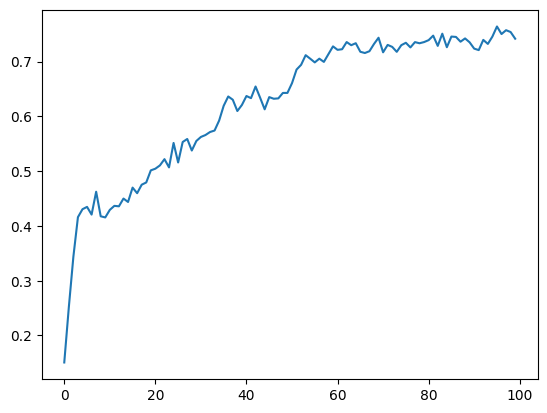

In [93]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"])

In [94]:
def accuracy(real,pred):
    comp = real == prea
    return np.sum(comp)/(comp.shape[0]*comp.shape[1])

In [44]:
def predict(model,X):
    pred = model.predict(X)
    return np.argmax(pred,axis = -1,keepdims=True)

5
4
9/9 [==============================] - 1s 69ms/step


In [ ]:
X_test = ds.X_test
y_test = ds.y_test

In [58]:
y_train_pred = predict(unet,X_train)
print("train accuracy : " + accuracy(y_train,y_train_pred))


y_test_pred = predict(unet,X_test)
print("train accuracy : " + accuracy(y_train,y_train_pred))

(278, 8640, 1)

In [68]:


if np.nan in y_pred:
    print("pred")


if np.nan in y_train:
    print("train")

np.all()


278


0.4067404409805489

In [81]:
from sklearn.metrics import accuracy_score
score =accuracy_score(y_train[:-1],y_pred[:-1])

ValueError: unknown is not supported

In [79]:
score

NameError: name 'score' is not defined